In [1]:
import pandas as pd
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [3]:
import numpy as np
import torch
np.random.seed(1234)
_ = torch.manual_seed(123)

In [4]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [17]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [8]:
df_train['event'].values

array([0, 1, 0, ..., 1, 0, 0], dtype=int32)

In [9]:
import torchtuples as tt
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [10]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.9410,	val_loss: 2.7390
1:	[0s / 0s],		train_loss: 2.6505,	val_loss: 2.4826
2:	[0s / 0s],		train_loss: 2.3820,	val_loss: 2.1576
3:	[0s / 0s],		train_loss: 2.0701,	val_loss: 1.8588
4:	[0s / 0s],		train_loss: 1.7658,	val_loss: 1.5957
5:	[0s / 0s],		train_loss: 1.5469,	val_loss: 1.4389
6:	[0s / 0s],		train_loss: 1.4433,	val_loss: 1.3934
7:	[0s / 0s],		train_loss: 1.4065,	val_loss: 1.3803
8:	[0s / 0s],		train_loss: 1.3860,	val_loss: 1.3817
9:	[0s / 0s],		train_loss: 1.3658,	val_loss: 1.3787
10:	[0s / 0s],		train_loss: 1.3559,	val_loss: 1.3737
11:	[0s / 0s],		train_loss: 1.3435,	val_loss: 1.3680
12:	[0s / 0s],		train_loss: 1.3365,	val_loss: 1.3630
13:	[0s / 0s],		train_loss: 1.3202,	val_loss: 1.3615
14:	[0s / 0s],		train_loss: 1.3277,	val_loss: 1.3633
15:	[0s / 0s],		train_loss: 1.3238,	val_loss: 1.3685
16:	[0s / 0s],		train_loss: 1.3074,	val_loss: 1.3684
17:	[0s / 0s],		train_loss: 1.2919,	val_loss: 1.3692
18:	[0s / 0s],		train_loss: 1.3050,	val_loss: 1.3796
19:

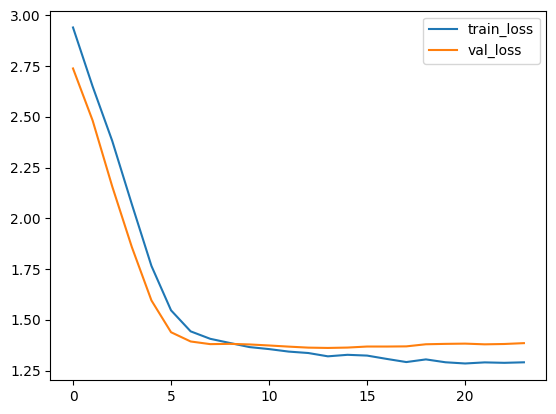

In [11]:
_ = log.plot()

In [12]:
log.to_pandas().val_loss.min()

1.3614822626113892

In [13]:
model.score_in_batches(val)

{'loss': 1.3614822626113892}

In [14]:
surv = model.predict_surv_df(x_test)

In [15]:
surv

,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0.000000,0.992897,0.998435,0.980808,0.993784,0.998309,0.998795,0.998629,0.998571,0.998668,0.993677,...,0.995469,0.991048,0.993102,0.996672,0.997620,0.991055,0.997443,0.999045,0.996971,0.991263
39.466667,0.839822,0.781172,0.888732,0.886111,0.806215,0.966593,0.979810,0.986355,0.750070,0.463376,...,0.890513,0.700541,0.777511,0.975670,0.909372,0.886011,0.884016,0.735622,0.752251,0.724283
78.933334,0.524427,0.614447,0.730556,0.705566,0.578115,0.854298,0.934547,0.951462,0.373013,0.269012,...,0.797105,0.446679,0.601350,0.910234,0.697780,0.773163,0.692357,0.218972,0.556894,0.547419
118.400002,0.370253,0.536105,0.579751,0.512677,0.406239,0.771717,0.869206,0.919434,0.199625,0.197884,...,0.709133,0.220793,0.407041,0.821162,0.537623,0.580344,0.383037,0.102424,0.498022,0.258984
157.866669,0.278369,0.475924,0.504410,0.442612,0.237532,0.669638,0.786793,0.813189,0.108183,0.136414,...,0.653073,0.108525,0.327569,0.735681,0.432333,0.464894,0.149044,0.052134,0.444196,0.100242
197.333344,0.215980,0.440372,0.432497,0.353974,0.116780,0.579970,0.673520,0.611735,0.047553,0.091042,...,0.520330,0.031874,0.254072,0.709656,0.366298,0.371782,0.049054,0.041340,0.411182,0.041686
236.800003,0.133786,0.341047,0.268678,0.233819,0.019420,0.497709,0.472868,0.432298,0.010535,0.051775,...,0.353835,0.004657,0.099504,0.631812,0.202295,0.210103,0.008608,0.013174,0.331067,0.005517
276.266663,0.053769,0.107682,0.214331,0.133147,0.002312,0.222693,0.301398,0.198194,0.001306,0.011446,...,0.277919,0.000497,0.034979,0.335579,0.097842,0.030920,0.000650,0.000970,0.139482,0.000222
315.733337,0.031695,0.011990,0.077923,0.038137,0.000676,0.150289,0.185155,0.151957,0.000362,0.003161,...,0.042633,0.000232,0.002458,0.320062,0.018863,0.020255,0.000503,0.000411,0.017146,0.000144
355.200012,0.003291,0.003808,0.002561,0.001680,0.000406,0.006911,0.003544,0.003048,0.000167,0.001959,...,0.001000,0.000172,0.000607,0.008632,0.002914,0.009701,0.000364,0.000304,0.004077,0.000117


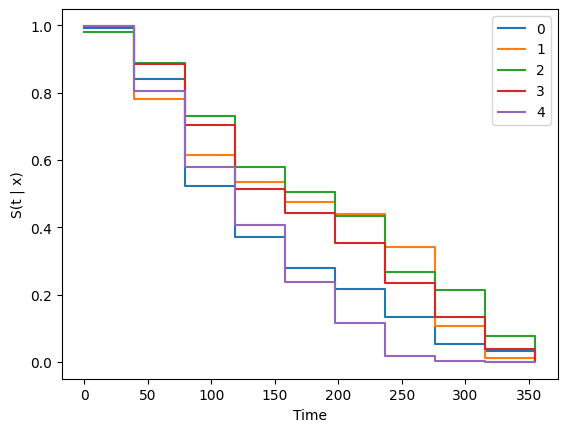

In [38]:
import matplotlib.pyplot as plt
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [39]:
surv = model.interpolate(10).predict_surv_df(x_test)

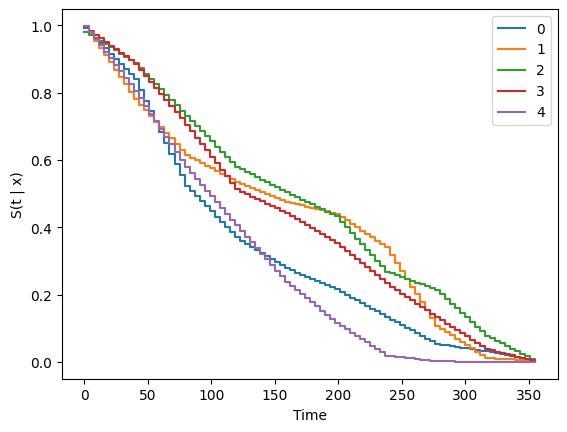

In [40]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [41]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [42]:
ev.concordance_td('antolini')

0.646191021238713

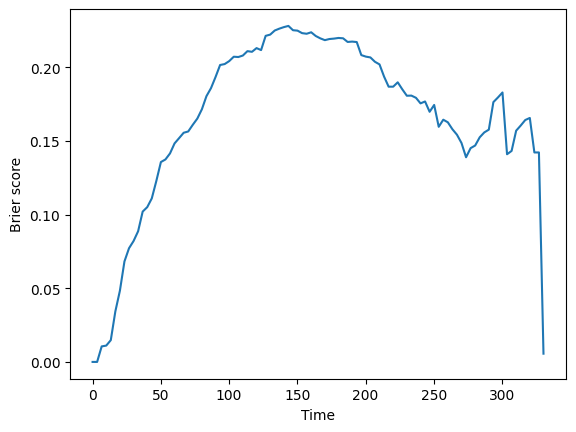

In [43]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [44]:
ev.integrated_brier_score(time_grid) 

0.16680649582771695

In [45]:
ev.integrated_nbll(time_grid) 

0.4986381483079722